<a href="https://colab.research.google.com/github/aliaa-anx/celebrity-recognition-model/blob/aliaa/VGG_19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
from google.colab import drive
import os

# This will ask for permission to access your Drive files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os


In [3]:
import zipfile
import os
zip_path = "/content/drive/MyDrive/VGGFace2_balanced_900_albumentations.zip"
extract_path = "/content/dataset"     # folder where files will be extracted
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")
# List the first few items
print(os.listdir(extract_path))


Dataset unzipped successfully!
['VGGFace2_balanced_900_albumentations']


In [5]:
import random
dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"

valid_ext = (".jpg", ".jpeg", ".png")
all_image_paths = [
    os.path.join(dp, f)
    for dp, dn, files in os.walk(dataset_path)
    for f in files if f.lower().endswith(valid_ext)
]
random.shuffle(all_image_paths)



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

IMAGE_SIZE = (224, 224)
target_per_class = 1500

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg','.png'))]
    num_existing = len(images)
    idx = 0
    while num_existing < target_per_class:
        img_path = os.path.join(class_folder, images[idx % len(images)])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        img = np.expand_dims(img, 0)

        for batch in datagen.flow(img, batch_size=1):
            aug_img = batch[0].astype(np.uint8)
            save_path = os.path.join(class_folder, f"aug_{num_existing}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            num_existing += 1
            break
        idx += 1

print("Dataset expanded to 1500 images per class!")


Dataset expanded to 1500 images per class!


normalization

In [24]:
import os
import random
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 15
# 3. Create dataset paths and shuffle

total_images = len(all_image_paths)
print(f"Found {total_images} total images.")

# Split into train / val / test
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]
test_paths = all_image_paths[train_size + val_size:]

print(f"Training: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")



Found 13500 total images.
Training: 9450, Validation: 2025, Test: 2025


In [25]:
# Map class names to integers
dataset_path = os.path.join(extract_path, "VGGFace2_balanced_900_albumentations")
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
class_to_int = {c:i for i,c in enumerate(sorted(os.listdir(dataset_path)))}


def process_path(file_path):
    # extract class folder name
    class_name = tf.strings.split(file_path, "/")[-2]

    # Python function to convert class name → label
    def get_label(x):
        x = x.numpy().decode("utf-8")   # convert Tensor → Python string
        return class_to_int[x]

    label = tf.py_function(get_label, [class_name], Tout=tf.int32)
    label.set_shape([])

    # load image
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)

    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(train_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
val_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(val_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
test_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(test_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))

print("Datasets ready ")



Datasets ready 


In [28]:


def build_vgg19_model(input_shape, num_classes):
    model = models.Sequential(name="VGG-19")

    # Add augmentation as the first layer
    # Note: These are only active during training, not validation/inference
    model.add(layers.Input(shape=input_shape))
    model.add(data_augmentation)

    # Block 1  contains 2 convultional layers and 1 max pooling layer
    # activation relu>> to add complexity and non-linearity to the model
    #padding same>> to maintain the spatial dimensions of the input (will be halved after max pooling)

    # first and 2nd blocks have 64 filters each and rest of the blocks as we go
    # deeper will have 128,256,512,512 filters respectively  to notioce more complex features as we go deeper


    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 2 contains 2 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 3 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 4 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 5 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


    # Flattening the layers to feed into fully connected layers(Dense layers considered the brain of the model)
    #model.add(layers.Flatten())

    #we have 3 dense layers in VGG-19
    #OPTION1 (HIGH RAM HAD R)
    # dense layer-1 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5)) #dropout to prevent overfitting


    # dense layer-2 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5))

    # output layer with number of neurons equal to number of classes and softmax activation function
    #model.add(layers.Dense(num_classes, activation='softmax')) #softmax for multiclass classification


    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))




    return model

print("VGG-19 architecture defined. ")

VGG-19 architecture defined. 


In [29]:
# full_dataset is your ImageFolder before splitting
num_classes = 15

input_shape = (224, 224, 3)  # for VGG-19

model = build_vgg19_model(input_shape, num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "VGG-19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,294,735 (77.42 MB)

 Trainable params: 20,294,735 (77.42 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.optimizers import Adam

# Adam optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the Keras model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # for integer class labels
    metrics=['accuracy']
)

print("Optimization setup done. Using Adam optimizer for Keras model.")


Optimization setup done. Using Adam optimizer for Keras model.


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    "best_vgg19_model.keras",   # file to save the model
    monitor="val_accuracy",  # metric to monitor
    save_best_only=True,     # save only the best version
    mode="max",
    verbose=1
)

# Optional: stop training early if no improvement
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,             # stop if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)


In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,               # you can increase epochs
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.0684 - loss: 2.7123
Epoch 1: val_accuracy improved from -inf to 0.08049, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 168s 544ms/step - accuracy: 0.0684 - loss: 2.7123 - val_accuracy: 0.0805 - val_loss: 2.7069
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.0785 - loss: 2.6974
Epoch 2: val_accuracy improved from 0.08049 to 0.12099, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 156s 528ms/step - accuracy: 0.0786 - loss: 2.6972 - val_accuracy: 0.1210 - val_loss: 2.3645
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.1177 - loss: 2.4088
Epoch 3: val_accuracy improved from 0.12099 to 0.15457, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 162s 546ms/step - accuracy: 0.1177 - loss: 2.4087 - val_accuracy: 0.1546 - val_loss: 2.2672
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.1460 - loss: 2.3090
Epo

In [33]:
from tensorflow.keras.models import load_model

model = load_model("best_vgg19_model.keras")

from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4  # you can adjust if needed
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",  # assuming integer labels
    metrics=["accuracy"]
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,                 # how many more epochs you want
    callbacks=[checkpoint_cb, earlystop_cb],  # reuse the same callbacks
)



Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5908 - loss: 1.1895
Epoch 1: val_accuracy improved from 0.63556 to 0.70469, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 170s 560ms/step - accuracy: 0.5909 - loss: 1.1893 - val_accuracy: 0.7047 - val_loss: 0.8343
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6463 - loss: 1.0503
Epoch 2: val_accuracy improved from 0.70469 to 0.72346, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 173s 584ms/step - accuracy: 0.6463 - loss: 1.0501 - val_accuracy: 0.7235 - val_loss: 0.8020
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6888 - loss: 0.9308
Epoch 3: val_accuracy improved from 0.72346 to 0.78765, saving model to best_vgg19_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 176s 594ms/step - accuracy: 0.6889 - loss: 0.9307 - val_accuracy: 0.7877 - val_loss: 0.6383
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7332 - loss: 0.8

**evaluation**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf


In [36]:
dataset_path = "/content/dataset/VGGFace2_balanced_900_albumentations"
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Get true labels from test_ds
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step


In [37]:
accuracy = np.mean(y_true == y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.0686


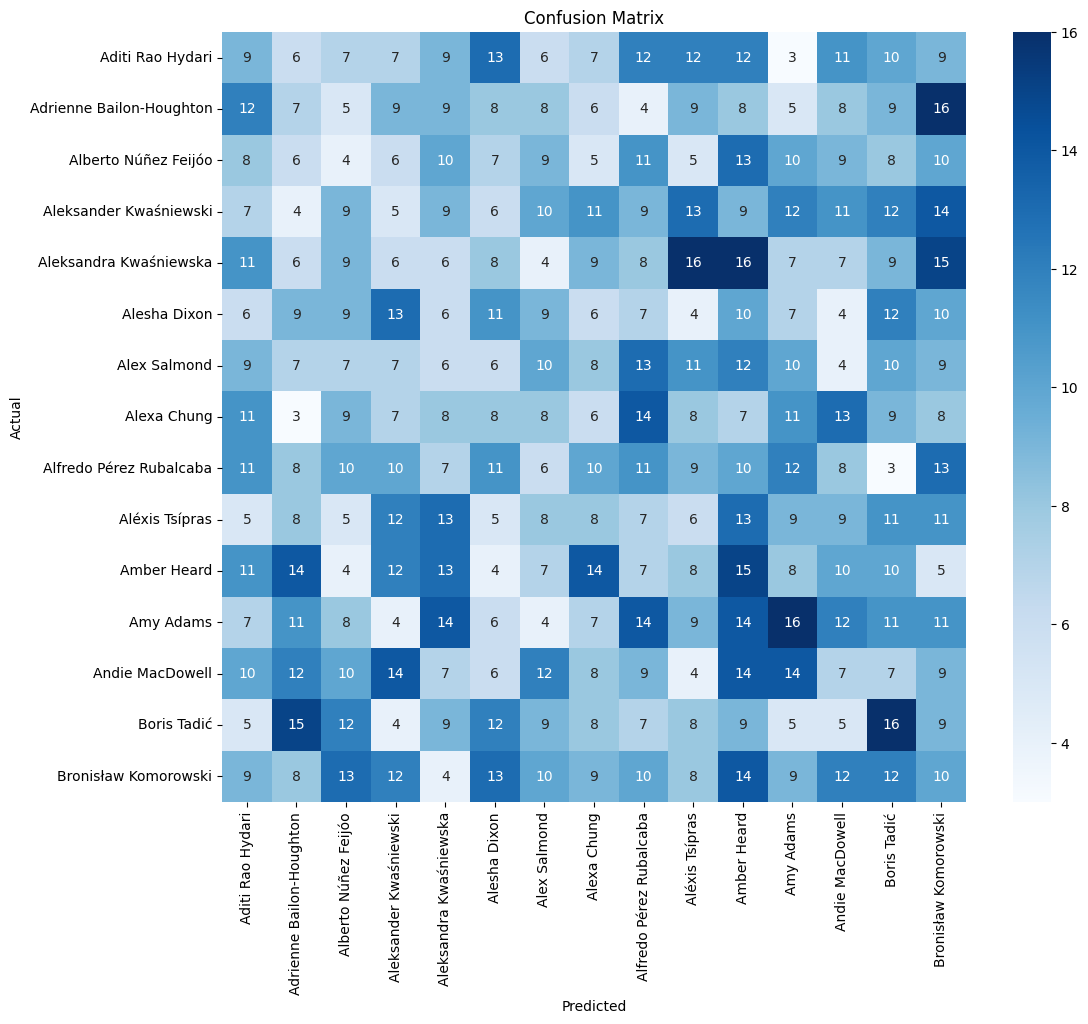

In [38]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

In [39]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.07      0.07      0.07       133
Adrienne Bailon-Houghton       0.06      0.06      0.06       123
    Alberto Núñez Feijóo       0.03      0.03      0.03       121
  Aleksander Kwaśniewski       0.04      0.04      0.04       141
  Aleksandra Kwaśniewska       0.05      0.04      0.04       137
            Alesha Dixon       0.09      0.09      0.09       123
            Alex Salmond       0.08      0.08      0.08       129
             Alexa Chung       0.05      0.05      0.05       130
 Alfredo Pérez Rubalcaba       0.08      0.08      0.08       139
          Aléxis Tsípras       0.05      0.05      0.05       130
             Amber Heard       0.09      0.11      0.09       142
               Amy Adams       0.12      0.11      0.11       148
         Andie MacDowell       0.05      0.05      0.05       143
             Boris Tadić       0.11      0.12      

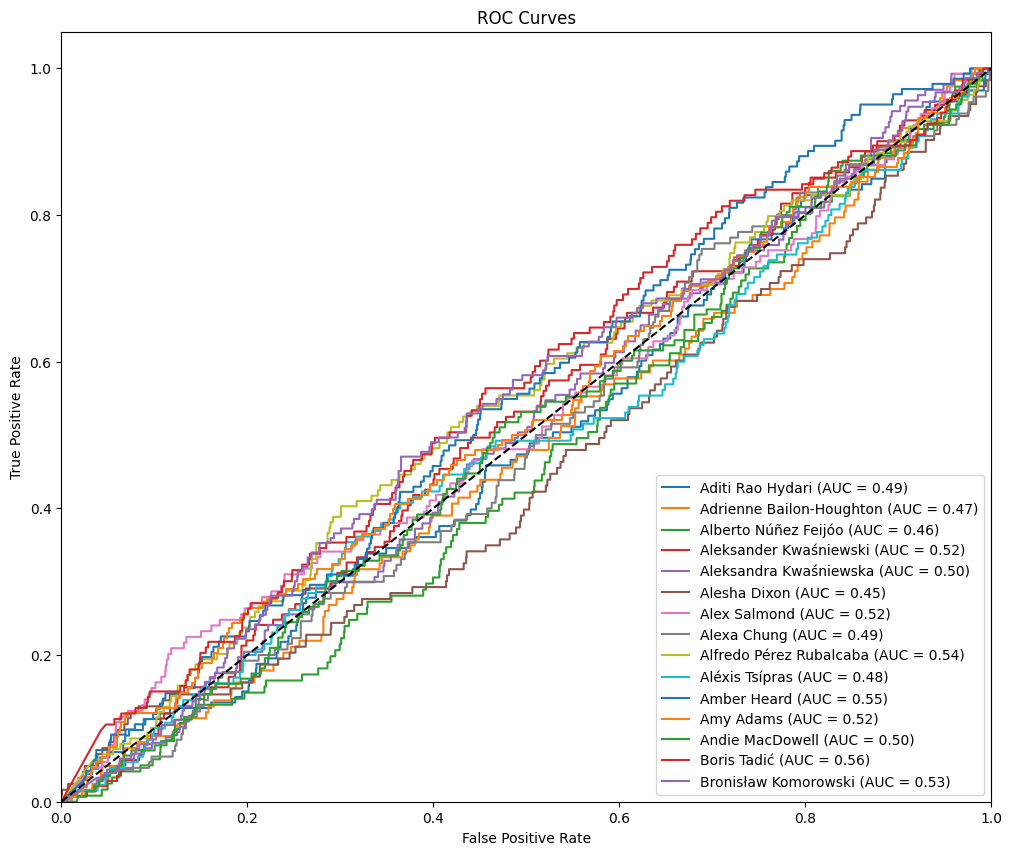

In [40]:
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()